In [291]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import skimage.draw as d
import skimage.transform as t
import time
%matplotlib inline

def show(img):
    plt.imshow(img, cmap = 'gray')
    plt.show()
    plt.close()

# New Data Set

## Second Try -- GOOD

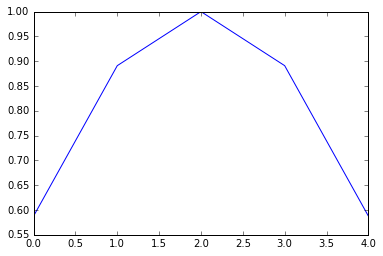

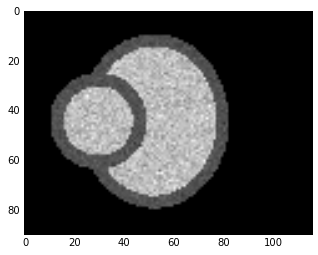

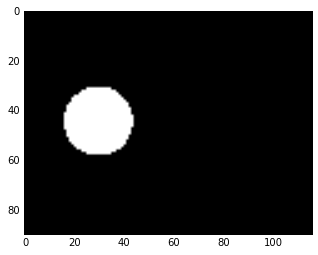

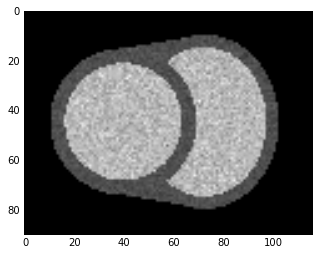

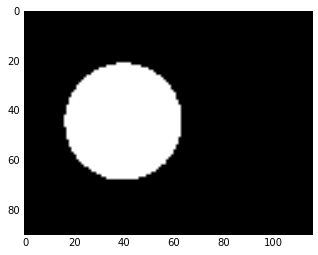

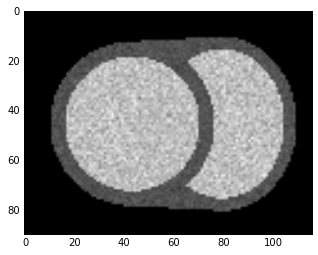

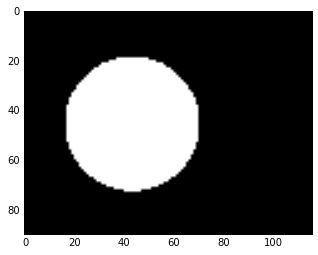

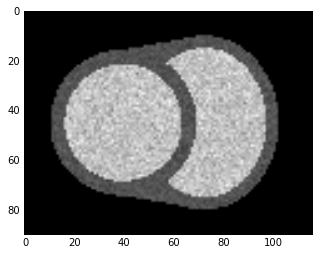

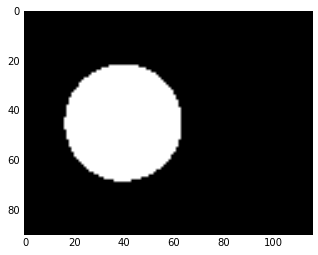

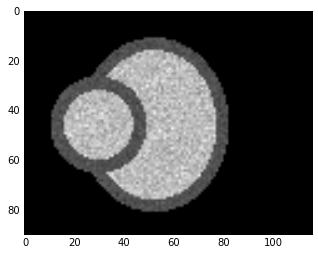

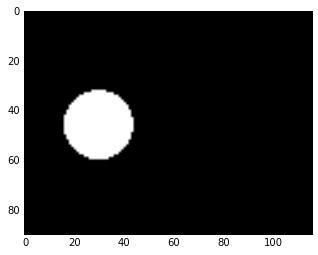

In [285]:
OUTER=43
INNER=100
TOP = 168
class Heart():
    def __init__(self, RE):
        self.base_lv_radius, self.base_lv_thick = RE[0]
        self.base_e_h, self.base_e_w = RE[1]

        self.v = 2*self.base_e_h +20
        self.h = 2*self.base_lv_radius + self.base_e_w + 20
        self.canva = np.zeros((self.v,self.h))

    def find_nbor(self, point, ctr):
        target = []
        x, y = ctr
        px, py = point[0], point[1]
        for i, pair in enumerate(zip(x,y)):
            _x, _y = pair 
            px, py = point[0], point[1]
            array  = np.array([_x, _y])
            # print point, array
            if _x<=px+1 and _x>=px-1 and _y<=py+1 and _y>=py-1 and (py!=_y or px!=_x):
                already = False
                for i in target:
                    if (array==i).all(): already = True
                
                if not already: target.append(array)
                              
        assert len(target)==2, "WTF? target{0} point{1}".format(target, point)
        return target
    
    def random_center(self, radius, ctr, point = None):
        """find the center of a circle tangent to outer contour"""
        N = len(ctr[0])
        good = False
        
        if point is None:
            start = np.random.choice(N-1)
            point  = np.array([ctr[0][start], ctr[1][start]])

        dots = zip(ctr[0], ctr[1])
        while not good:
            # random shift point from origin
            point = point + np.random.randn()*10
            distance = [ np.linalg.norm(x-point) for x in dots]
            idx = np.argmin(distance)
            point = dots[idx]
            
            #locate the center
            vec   = self.find_nbor(point, ctr)
            vec   = vec[0] - vec[1]
            dis   = np.linalg.norm(vec)
            Y = abs(round(radius*vec[1]/dis))
            X = abs(round(radius*vec[0]/dis))
            if midl[0]>self.h:
                Y = midl[0]-Y
            else:
                Y = midl[0]+Y
            if midl[1]>self.w:
                X = midl[1]-X
            else:
                X = midl[1]+X
        
            if X-radius>0 and X+radius<2*self.w and Y-radius>0 and Y+radius<2*self.h:
                good = True   

        center = np.array((Y,X))
        radius_vec = center - point 
        return center, radius_vec
    
    def add_LV(self, scale, drift=10):
        radius = self.lv_radius = self.base_lv_radius * scale
        thick  = self.lv_thick  = self.base_lv_thick * (4+scale)/5
        
        # get center
        shift = np.array([np.random.randn()*drift, radius])
        
        # print shift
        center = np.array([self.v/2, 10]) + shift
        self.lv_center = center
        self.lv_radius_vec = np.array([0,radius])

        # get points
        self.lv_big = d.circle(center[0], center[1], radius)
        self.lv_small = d.circle(center[0], center[1], radius-thick)
        #self.lv_ctr = d.circle_perimeter(int(center[0]), int(center[1]), int(radius))
    
    def add_Ellipse(self, scale = 1, thick = 5):
        """h for vertical， w for horizontal"""
        h = self.e_h = self.base_e_h * scale
        w = self.e_w = self.base_e_w * scale
        
        # e and lv should not be too close
        shift = self.e_w/8
        center = self.lv_center + self.lv_radius_vec
        center[1] += shift
        
        self.e_center = center 
        self.e_thick = thick
        self.e_big  = d.ellipse(center[0], center[1], h, w)
        self.e_small= d.ellipse(center[0], center[1], h-thick, w-thick)
        # self.ctr = d.ellipse_perimeter(h+5, w+5, h, w)
        
    def add_background(self):
        dis = self.lv_radius**2/self.e_h
        poly = np.array((
        (self.e_center[0]+self.e_h, self.e_center[1]),
        (self.e_center[0]-self.e_h, self.e_center[1]),
        (self.lv_center[0]-self.lv_radius, self.lv_center[1]),
        (self.lv_center[0]+self.lv_radius, self.lv_center[1]),
        ))
        self.back = d.polygon(poly[:, 0], poly[:, 1])
        
    
    def draw_LV(self):
        self.canva[self.lv_big[0],   self.lv_big[1]]   = np.random.randn(self.lv_big[0].size)*5+OUTER
        self.canva[self.lv_small[0], self.lv_small[1]] = np.random.randn(self.lv_small[0].size)*10+INNER

    def draw_E(self):
        self.canva[self.e_big[0], self.e_big[1]]   = np.random.randn(self.e_big[0].size)*5+OUTER
        self.canva[self.e_small[0], self.e_small[1]] = np.random.randn(self.e_small[0].size)*10+INNER
        
    def draw_background(self):
        self.canva[self.back[0], self.back[1]] = np.random.randn(self.back[0].size)*5+OUTER
    
    def make_label(self):
        bg = np.zeros_like(self.canva)
        bg[self.lv_small[0], self.lv_small[1]] = 1
        self.label = bg
        
    def show(self):
        plt.imshow(self.canva, cmap = 'gray')
        plt.show()
        #u.figure.clear()
        #plt.clf()
        plt.close()
        
    def clean(self):
        self.canva = np.zeros((self.v,self.h))

    def _make(self, scale):
        self.add_LV(scale, drift=1)
        self.add_Ellipse()
        self.add_background()
        self.make_label()
            
        self.draw_background()
        self.draw_E()
        self.draw_LV()
        #self.show()
    
    def make(self, scales=None):
        self.series = []
        self.labels  = []
        if scales is None:
            scales = [1]
        
        for s in scales:
            self.clean()
            self._make(s)
            self.series.append(self.canva)
            self.labels.append(self.label)

    def move(self, base, num, plot = False):
        base = 1.0/base
        kkk = np.linspace(base*np.pi ,(1-base)*np.pi, num=num)
        scale = np.sin(kkk)
        
        
        if plot:
            plt.plot(scale)
            plt.show()
            
        self.make(scale)
        
        assert len(self.series)==num, "LENTH ERROR {}".format(len(self.series))

        if plot:
            for i in range(num):
                show(self.series[i])
                show(self.labels[i])
                
        return self.series, self.labels

RE = [(33,6),(35,30)]
ht = Heart(RE)
series = ht.move(5,5,plot=True)

## Rotate and reshape

In [197]:
def my_rotate(angle):   
    ht = Heart(RE)
    ht.make()
    canva = ht.canva
    cv = t.rotate(canva, angle, resize=True)

    mask = (cv!=0)
    lower_x, lower_y = 0 , 0
    while (cv[lower_x,:]==0).all(): 
        lower_x +=1    
    while (cv[:, lower_y]==0).all():
        lower_y +=1

    upper_x, upper_y = cv.shape
    upper_x -=1
    upper_y -=1
    while (cv[upper_x,:]==0).all():
        upper_x -=1
    while (cv[:, upper_y]==0).all():
        upper_y -=1

    cv = cv[lower_x:upper_x, lower_y:upper_y]

    #plt.imshow(cv, cmap = 'gray')
    #plt.show()
    #plt.close()
    return cv

## Background Pic, River

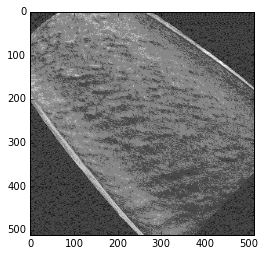

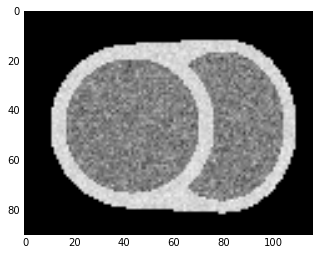

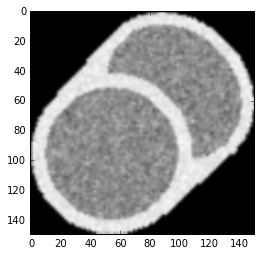

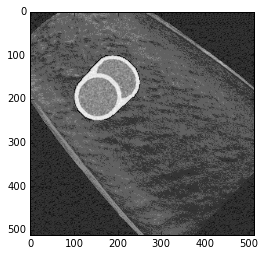

In [221]:
INNER = 60
OUTER = 100
SHAPE = (256,256)
BIG_SHAPE = (512,512)
river = misc.imread('background.jpg', mode='P')
plt.imshow(river, cmap = 'gray')
plt.show()
#s_r = misc.imresize(river, SHAPE)
#print s_r[0,0]
#print s_r[178,178]
#print s_r.max()

cv = my_rotate(45)
cv = misc.imresize(cv, (150,150))
show(cv)

UPRIGHT=(100,100)
x, y = cv.shape
mas = (cv!=0)
river_heart = river.copy()
river_heart[UPRIGHT[0]:UPRIGHT[0]+x, UPRIGHT[1]:UPRIGHT[1]+y][mas] = cv[mas] 
show(river_heart)

## All in one

In [293]:
INNER = 130
OUTER = 80

class Maker(object):
    
    def __init__(self, re):
        """RE has the info for LV and E"""
        self.RE = re
        self.heart = Heart(re)
        self.background = misc.imread('background.jpg', mode='P')
    
    def rotate(self, img, label, angle):
        assert img.shape==label.shape
        
        img =   t.rotate(img, angle, resize=True)
        label = t.rotate(label, angle, resize=True)
        assert img.shape==label.shape

        lower_x, lower_y = 0 , 0
        while (img[lower_x,:]==0).all(): 
            lower_x +=1    
        while (img[:, lower_y]==0).all():
            lower_y +=1

        upper_x, upper_y = img.shape
        upper_x -=1
        upper_y -=1
        while (img[upper_x,:]==0).all():
            upper_x -=1
        while (img[:, upper_y]==0).all():
            upper_y -=1

        img = img[lower_x:upper_x, lower_y:upper_y]
        label = label[lower_x:upper_x, lower_y:upper_y]

        return img, label
    
    def combine(self, heart, label, center):
        if center is None:
            x, y = self.background.shape
            center = (round(x/2),round(y/2))
        
       
        hx, hy = heart.shape
        x, y = center
        x = x + np.random.randn()*4 - hx/2
        y = y + np.random.randn()*4 - hy/2
        
        #make image
        mask = (heart!=0)
        img = self.background.copy()
        img[x:x+hx, y:y+hy][mask] = heart[mask]
        
        #make label
        ll = np.zeros_like(img)
        ll[x:x+hx, y:y+hy] = label 
        return img, ll
    
    
    def generate(self, num_pic, angle, base=6, plot=False, center=None, shape=None):
        shape = 300 if shape is None else shape
        if not isinstance(shape, tuple):
            shape = int(round(shape+np.random.randn()*shape/100))
        else:
            shape = tuple([ int(round(x+np.random.randn()*x/100))
                                                  for x in shape ])

            
        series, labels = self.heart.move(base, num_pic)
        self.imgs = []
        self.labels = []
        for i in range(num_pic):
            
            img, label = series[i], labels[i]
            assert img.mean() > 0
            if not isinstance(shape, tuple):
                assert isinstance(shape, int), shape
                s = shape
                m_x = np.max(img.shape)
                idx = np.argmax(img.shape)
                scale = s/m_x
                shape = [0,0]
                shape[idx] = s
                shape[1-idx] = int(round(img.shape[1-idx]*scale))
                shape = tuple(shape)
            
            #print '{} to {}'.format(shape, img.shape)
            #img = misc.imresize(img, shape)
            img, label = self.rotate(img, label, angle)
            img, label = self.combine(img,label,center)
            self.imgs.append(img)
            self.labels.append(label)
            
            if plot:
                show(img)
                show(label)
         
        
        
        
    
    def save(self, perfix='', downsample = False):
        #TODO downsample
        now = time.ctime(int(time.time()))
        now = now.split(' ')
        now = now[2]+'-'+now
        perfix = perfix+'[%d]'%(len(self.imgs))+now
        #os.mkdir(folder)
        
        if downsample:
            raise NotImplementedError('Not downsample')
        
        imgs = np.stack(self.imgs)
        labels = np.stack(self.labels)
        print imgs.shape
        print labels.shape
        
        import cPickle as pk
        with open(perfix+'.pk','w') as f:
            pk.dump(imgs, f)
            pk.dump(labels, f)
        
        
        
    
    
RE = [(100,20),(105,66)]
g = Maker(RE)
g.generate(10, 45)
g.save()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


TypeError: cannot concatenate 'str' and 'list' objects

## Heart,  Annulus with Circle

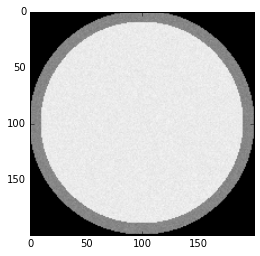

In [6]:
OUTER=43
INNER=75
TOP = 168
class LV():
    def __init__(self, radius, width):
        self.radius = radius
        self.width  = width
        self.big = big = d.circle(radius-1, radius-1, radius)
        self.small = small = d.circle(radius-1, radius-1, radius-width)
        self.canva = None
        
        
    def show(self):
        if self.canva is None:
            self.canva = np.zeros((2*self.radius,2*self.radius))
            self.canva[self.big[0], self.big[1]] = np.random.randn(self.big[0].size)*2+OUTER
            self.canva[self.small[0],self.small[1]] = np.random.randn(self.small[0].size)*1.5+INNER

        plt.imshow(self.canva, cmap = 'gray')
        plt.show()
        plt.close()
        
LV(100,10).show()        

## First Try --Not Good

-------------force out----------------
-------------force out----------------
-------------force out----------------


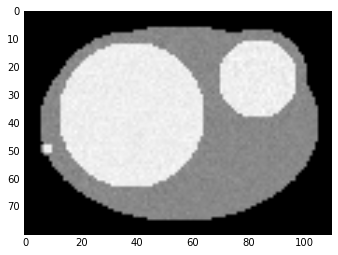

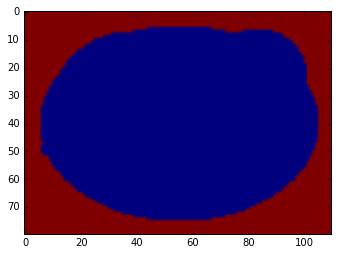

In [51]:
OUTER=43
INNER=75
TOP = 168
class Heart():
    def __init__(self,w,h):
        self.w = w
        self.h = h
        self.fill= d.ellipse(h+5, w+5, h, w)
        self.ctr = d.ellipse_perimeter(h+5, w+5, h, w)
        self.sorted_ctr = None
        self.canva = np.zeros((2*self.h+10, 2*self.w+10))
        self.canva[self.fill[0],     self.fill[1]]     = np.random.randn(self.fill[0].size)*1.5+OUTER
       
    def sort_ctr(self):
        if self.sorted_ctr is not None:
            return
        sort=[[],[]]
        from copy import deepcopy
        ctr = deepcopy(self.ctr)
        x, y = ctr
        x = list(x)
        y = list(y)
        while len(x)>0:
            target = max(x)
            x_list, y_list = [] , []
            while target in x:
                idx = x.index(target)
                x_list.append(x.pop(idx))
                y_list.append(y.pop(idx))

            y_list = sorted(y_list)
            sort[0] += x_list
            sort[1] += y_list
            
        self.sorted_ctr = (np.array(sort[0]), np.array(sort[1]))
        
    def find_nbor(self, point, ctr):
        target = []
        x, y = ctr
        px, py = point[0], point[1]
        for i, pair in enumerate(zip(x,y)):
            _x, _y = pair 
            px, py = point[0], point[1]
            array  = np.array([_x, _y])
            # print point, array
            if _x<=px+1 and _x>=px-1 and _y<=py+1 and _y>=py-1 and (py!=_y or px!=_x):
                already = False
                for i in target:
                    if (array==i).all(): already = True
                
                if not already: target.append(array)
                              
        assert len(target)==2, "WTF? target{0} point{1}".format(target, point)
        return target
    
    def random_center(self, radius, ctr):
        N = len(ctr[0])
        good = False
        
        while not good:
            start = np.random.choice(N-1)

            midl  = np.array([ctr[0][start], ctr[1][start]])
            vec   = self.find_nbor(midl, ctr)
            vec   = vec[0] - vec[1]
            dis   = np.linalg.norm(vec)
            Y = abs(round(radius*vec[1]/dis))
            X = abs(round(radius*vec[0]/dis))
            if midl[0]>self.h:
                Y = midl[0]-Y
            else:
                Y = midl[0]+Y
            if midl[1]>self.w:
                X = midl[1]-X
            else:
                X = midl[1]+X
        
            if X-radius>0 and X+radius<2*self.w and Y-radius>0 and Y+radius<2*self.h:
                good = True   

        return (Y,X)
    
    def add_LV(self, radius, width):
        self.lv_radius = radius
        self.lv_width  = width
        self.lv_center = center = self.random_center(radius, self.ctr)
        self.lv_big = d.circle(center[0], center[1], radius)
        self.lv_small = d.circle(center[0], center[1], radius-width)
        self.lv_ctr = d.circle_perimeter(int(center[0]), int(center[1]), int(radius))
    
    
    def _noise(self, start, lower, upper):
        ctr = self.lv_ctr
        good = False
        num = 0
        while not good:
            midl  = np.array([ctr[0][start], ctr[1][start]])
            # print '>>>>>>>>>>start',midl
            nbors = self.find_nbor(midl,ctr)
            vec   = nbors[0] - nbors[1]
            vec = np.abs(vec)
            div = np.min(vec)
            # print 'BBBB, vec', vec
            # print '---div', div
            if div>0:
                vec = vec/div     
            # print '>>vec', vec
            lvcenter = self.lv_center
            head = np.zeros_like(lvcenter)

            r = midl - lvcenter
            # print '>>direct', r
            head[0] = vec[1] * r[0]/abs(r[0]) if r[0]!=0 else vec[1]
            head[1] = vec[0] * r[1]/abs(r[1]) if r[1]!=0 else vec[0]
            head = head.astype('int')
            assert np.linalg.norm(head)>0, "HEAD ERROR midl is{}".format(midl)
            # print '>>head', head

            base = midl.copy()
            count = 0
            while self.canva[base[0],base[1]] != 0:
                base += head
                count +=1 

                if not ( base[0]>=0 and base[0]<self.h*2 and base[1]>=0 and base[1]<self.w*2
                            ):
                    #print 'ERROR'
                    break
                
                if count>=100:
                    #print 'ERROR' , count
                    break
                
                # print 'in changing', base, self.canva[base[0],base[1]]


            # print '>>base end', base, '#',count
            center = (base+midl)/2
            radius = np.linalg.norm(base-midl)/2
            # print '<<<<<<<<radius', self.noise_radius
            if radius >= lower and radius <= upper:
                good = True
            
            num += 1
            if num >=500:
                print '-------------force out----------------'
                good = True
            
        outer = d.circle(center[0],center[1], radius)
        width = min(self.lv_width, radius*0.3)
        inner = d.circle(center[0],center[1], radius-width)
        rslt = {
            'midl':midl,
            'base':base,
            'center':center,
            'radius':radius,
            'outer' :outer,
            'inner' :inner
        }
        return rslt

    def add_noise(self, requires):
        """requires should be list of tuples of upper bounds and lower bounds"""
        ctr = self.lv_ctr
        N = len(ctr[0])
        self.noises = {}
        prev = []
        for r in requires:
            # if len(prev) == 0:
            start = np.random.choice(N-1)
            #else:
                #for starts in prev:
                    
            self.noises[r] = self._noise(start, r[0], r[1])
    
    def draw_noise(self):
        for k, v in self.noises.items():
            self.canva[v['outer'][0],    v['outer'][1]] = np.random.randn(v['outer'][0].size)*2+OUTER            
            self.canva[v['inner'][0],    v['inner'][1]] = np.random.randn(v['inner'][0].size)*2+INNER            
        
    def draw_lv(self):
        self.canva[self.lv_big[0],   self.lv_big[1]]   = np.random.randn(self.lv_big[0].size)*2+OUTER
        self.canva[self.lv_small[0], self.lv_small[1]] = np.random.randn(self.lv_small[0].size)*1.5+INNER
        
    def make(self, r, ww):
        
        self.add_LV(r,ww)
        self.draw_lv()
        
        R = [
            (8,15),
            (15,25),
            (12,20)
        ]
        self.add_noise(R)
        self.draw_noise()

        
        plt.imshow(self.canva, cmap='gray')
        plt.show()
        plt.close()
        
        # self.add_noise(7,15)
        
        # midl_circle = d.circle(self.noise_midl[0], self.noise_midl[1], 2)
        # self.canva[midl_circle[0], midl_circle[1]] = 10
        
        
        # plt.imshow(self.canva, cmap='gray')
        # plt.show()
        # plt.close()
        self.mask = (self.canva==0)
        plt.imshow(self.mask)
        plt.show()
        plt.close()


h = Heart(50,35)
h.make(30 , 4)